In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

np.random.seed(42)

# Sparse linear regression and compressed sensing

$$\left\{
\begin{aligned}
&x_i \sim \rho \, \mathcal{N} (x; 0, 1) + (1 - \rho) \, \delta(x) \\
&y_\mu \sim \mathcal{N} \big(y_\mu; \sum_i F_{\mu i} x_i, \sigma^2\big)
\end{aligned}
\right.
$$

$$P({\bf x} | {\bf y}, F) \propto \prod_{\mu} \mathcal{N} \big(y_\mu; \sum_i F_{\mu i} x_i, \sigma^2\big) \, \prod_i P_0 (x_i)$$

In [2]:
def sample_instance(size_x, frac_nonzeros, rows_to_columns, var_noise):
    """Samples F from P(F) and {x, y} from P(x, y | F)"""
    
    # Some pre-processing
    size_nonzeros = int(np.ceil(frac_nonzeros * size_x))
    size_y = int(np.ceil(rows_to_columns * size_x))
    
    # Sample x from P_0(x)
    x0 = np.zeros(size_x)
    nonzeros = np.random.choice(size_x, size_nonzeros, replace=False)
    x0[nonzeros] = np.random.randn(size_nonzeros)
    
    # Generate F and y = Fx + noise
    F = np.random.randn(size_y, size_x) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_y)
    y = F.dot(x0) + noise

    return x0, F, y

<StemContainer object of 3 artists>

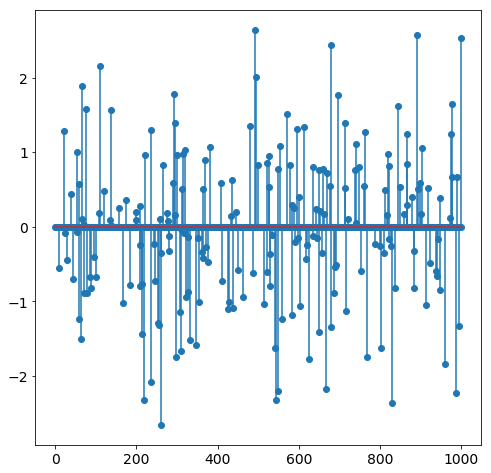

In [3]:
x, F, y = sample_instance(1000, 0.2, 0.5, 1e-5)
plt.stem(x)

In [4]:
def iterate_amp(F, y, var_noise, frac_nonzeros,
                x0=None, max_iter=100, tol=1e-7, verbose=1):
    """Iterates AMP to solve y = Fx, w/ x Bernoulli-Gaussian"""
    
    # Some pre-processing
    size_y, size_x = F.shape
    sqrF = F * F
    
    # Initialize variables
    A = np.ones(size_x)
    B = np.zeros(size_x)
    a = np.zeros(size_x)
    c = np.ones(size_x)
    
    a_old = np.zeros(size_x)
    
    v = np.ones(size_y)
    w = np.zeros(size_y)
    
    for t in range(max_iter):
        # Store old v and compute new v and w
        v_old = np.copy(v)
        v = sqrF.dot(c)
        w = F.dot(a) - v * ((y - w) / (var_noise + v_old))
        
        # Iterate A and B
        A = sqrF.T.dot(1 / (var_noise + v))
        B = F.T.dot((y - w) / (var_noise + v)) + A * a
        
        # Store old mean and compute new mean/variance
        a_old = np.copy(a)
        a, c = prior(A, B, frac_nonzeros)
        
        # Compute metrics
        diff = np.mean(np.abs(a - a_old))
        mse = np.mean((a - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mse))
        
        # Check for convergence
        if diff < tol:
            break
            
    return a

In [5]:
def prior(A, B, rho):
    """Computes mean and variance of P(x) e^{-A/2 x^2 + Bx}, w/ P(x) Bernoulli-Gaussian"""
    
    # let x = s * t, with s ~ Bernoulli(p) and t ~ N(0, 1); then m = E(t), v = Var(t), p = E(s)
    m = B / (1 + A)
    v = 1 / (1 + A)
    p = rho / (rho + (1 - rho) * np.sqrt(1 + A) * np.exp(-.5 * m ** 2 / v))
    
    # compute E(s * t) and Var(s * t) from E(t), Var(t) and E(s)
    a = p * m
    c = p * v + p * (1 - p) * m ** 2
    return a, c

In [6]:
iterate_amp(F, y, var_noise=1e-5, frac_nonzeros=0.2, x0=x)

t = 0, diff = 0.122576; mse = 0.117189
t = 1, diff = 0.0632452; mse = 0.0780846
t = 2, diff = 0.0603051; mse = 0.0514934
t = 3, diff = 0.0542836; mse = 0.0352217
t = 4, diff = 0.0455386; mse = 0.0228074
t = 5, diff = 0.0386528; mse = 0.0143444
t = 6, diff = 0.0299433; mse = 0.00866915
t = 7, diff = 0.0218652; mse = 0.00555142
t = 8, diff = 0.0170524; mse = 0.00359653
t = 9, diff = 0.0124484; mse = 0.0022878
t = 10, diff = 0.0107794; mse = 0.00130903
t = 11, diff = 0.00859677; mse = 0.000774696
t = 12, diff = 0.00783413; mse = 0.000396957
t = 13, diff = 0.0060447; mse = 0.000203641
t = 14, diff = 0.00418152; mse = 9.81591e-05
t = 15, diff = 0.00285909; mse = 4.43663e-05
t = 16, diff = 0.00171064; mse = 2.09968e-05
t = 17, diff = 0.00105536; mse = 1.34868e-05
t = 18, diff = 0.000684322; mse = 1.07192e-05
t = 19, diff = 0.000486816; mse = 9.84959e-06
t = 20, diff = 0.000308212; mse = 8.96961e-06
t = 21, diff = 0.000208663; mse = 8.573e-06
t = 22, diff = 0.000135874; mse = 8.31541e-06
t = 

array([ 1.68217499e-05,  4.80371140e-07, -1.01451750e-06,  1.79921531e-05,
       -7.82259710e-06,  2.49968882e-06,  2.06210012e-05,  1.82945905e-05,
        1.26858050e-06, -5.45030429e-06, -5.72205909e-01,  4.89871136e-06,
        8.65125949e-06,  3.11088687e-06,  7.60160326e-06,  6.81566463e-05,
       -7.58775805e-07,  1.13312554e-06, -2.56536089e-06, -4.66560498e-06,
       -7.48282222e-05,  2.07349398e-06, -4.50635532e-07,  1.29806713e+00,
        1.60658607e-06, -8.40071223e-02,  1.24512223e-05, -3.78498932e-05,
       -5.59551755e-06, -1.73331288e-05, -4.45414785e-01, -7.32361362e-06,
       -1.13730906e-05,  1.20776784e-05,  4.60789524e-05, -3.23794138e-06,
        8.22594054e-05, -1.67114172e-05,  1.45400019e-05,  4.39417728e-01,
       -3.65615402e-06,  3.11641232e-04, -1.66275872e-06, -3.06964942e-07,
       -7.07540040e-01,  1.98309656e-06, -4.46489812e-05,  5.92740003e-07,
        1.65777363e-05,  2.65547321e-07,  5.53256242e-06,  2.52118388e-05,
       -2.17773289e-05, -